# Part 1:

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Effective sample size for df parameter: df    4.28
Name: ess_bulk, dtype: float64


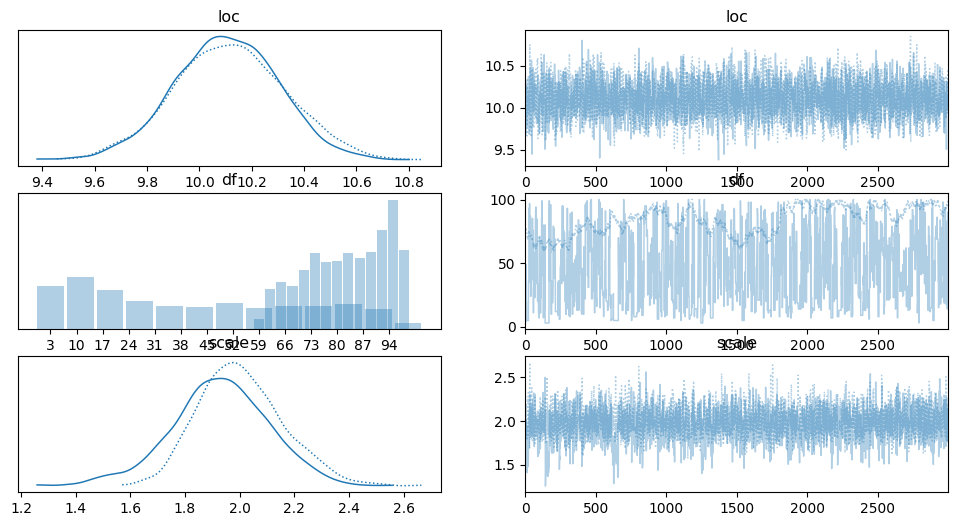

In [ ]:
import pymc as pm
import arviz as az

# True values from the data generation step
mu_0, sigma_0 = 0, 10
n, loc_true, scale_true, df_true = 100, 10, 2, 15

# Generate some data
x = stats.t(df=df_true, loc=loc_true, scale=scale_true).rvs(n)

# Bayesian model specification using PyMC
with pm.Model() as model:
    # Priors for unknown model parameters
    loc = pm.Normal('loc', mu=mu_0, sigma=sigma_0)
    scale = pm.HalfNormal('scale', sigma=5)
    df = pm.DiscreteUniform('df', lower=1, upper=100)

    # Likelihood (sampling distribution) of observations
    x_obs = pm.StudentT('x_obs', mu=loc, lam=1/scale**2, nu=df, observed=x)

    # Posterior sampling using default PyMC sampler (NUTS which is an advanced form of HMC)
    trace = pm.sample(draws=3000, tune=2000, target_accept=0.95)

# Analyzing the posterior samples
az.plot_trace(trace)
az.summary(trace, round_to=2)

# Explore and describe the sample sizes needed for the df parameter
df_summary = az.summary(trace, var_names=['df'], round_to=2)
df_ess = df_summary['ess_bulk']
print(f"Effective sample size for df parameter: {df_ess}")

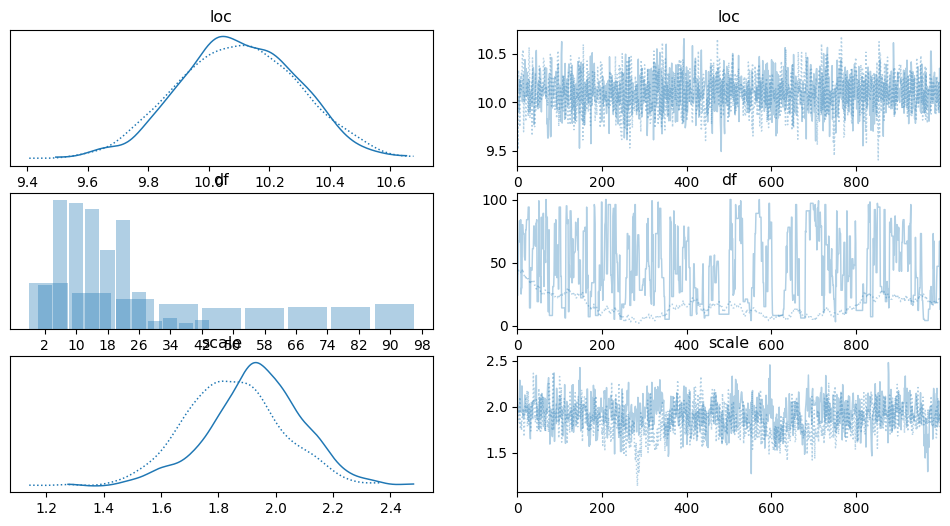

In [ ]:
import pymc as pm

with pm.Model() as t_norm_half_norm_discrete:
    loc = pm.Normal("loc", mu=0, sigma=10)
    scale = pm.HalfNormal("scale", sigma=5)
    df = pm.DiscreteUniform("df", lower=1,upper=100)
    x_obs = pm.StudentT("likelihood", mu=loc, sigma=scale, nu=df, observed=x)

with t_norm_half_norm_discrete:
    idata = pm.sample()

import arviz as az; az.plot_trace(idata);

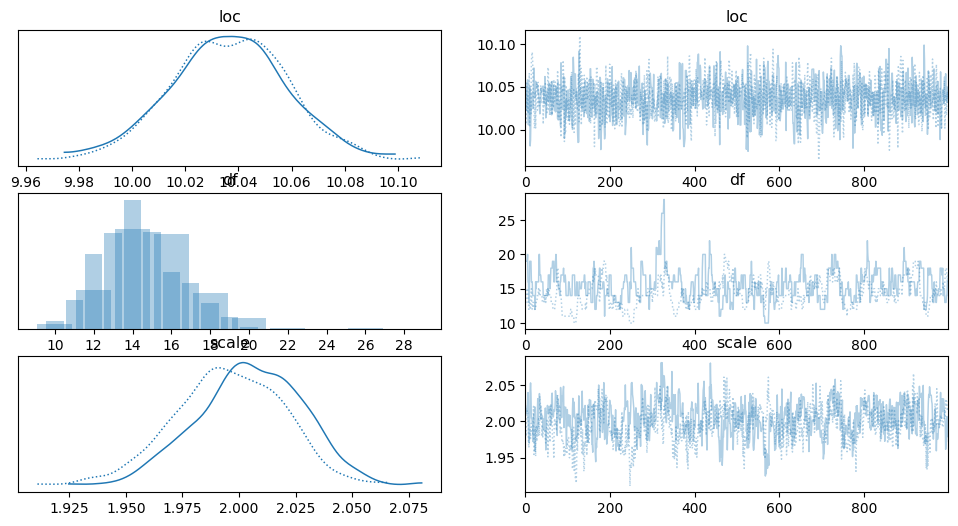

In [ ]:
n,loc_true,scale_true,df_true = 10000,10,2,15
x = stats.t(df = df_true, loc = loc_true, scale = scale_true).rvs(n)

with pm.Model() as t_norm_half_norm_discrete:
    loc = pm.Normal("loc", mu=0, sigma=10)
    scale = pm.HalfNormal("scale", sigma=5)
    df = pm.DiscreteUniform("df", lower=1,upper=100)
    x_obs = pm.StudentT("likelihood", mu=loc, sigma=scale, nu=df, observed=x)
    idata = pm.sample()

import arviz as az; az.plot_trace(idata);

# Part 2:

In [ ]:
import numpy as np
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pm.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pm.Normal("theta", mu=mu, sigma=tau, shape=J)

    # likelihood where observed information enters into the model
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

SEED = [20200207, 20240207]
with Centered_eight:
    fit_C = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with pm.Model() as NonCentered_eight:

    mu = pm.Normal("mu", mu=0, sigma=5)
    tau = pm.HalfCauchy("tau", beta=5)
    theta_tilde = pm.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pm.Deterministic("theta", mu + tau * theta_tilde)
    obs = pm.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pm.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})

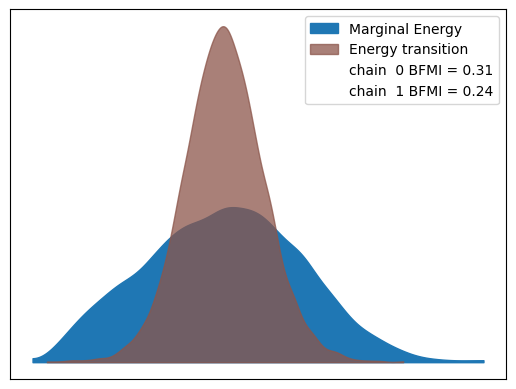

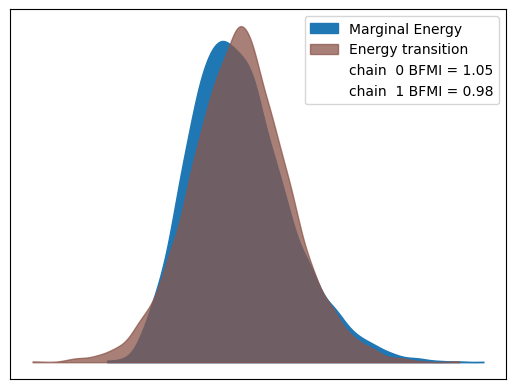

In [ ]:
import arviz as az
az.plot_energy(fit_C);
az.plot_energy(fit_NC);

Top Graph: "Centered" Parameterization Analysis: For both chains, the Bayesian Fraction of Missing Information (BFMI) is 0.31 and 0.24, respectively, which is a very low value. This indicates a mismatch between the total energy distribution and the energy transitions, raising the possibility of problems with sampling efficiency. These results suggest that the posterior distribution may be difficult for the Hamiltonian Monte Carlo (HMC) method to navigate successfully due to the "centered" parameterization.

The BFMI scores in the "Uncentered" Parameterization Evaluation (Bottom Graph) are much higher, coming in at 1.05 and 0.98, respectively. This indicates a better fit between the marginal energy distribution and energy transitions, indicating that the "uncentered" model improves the HMC sampler's ability to fully investigate the posterior distribution. This is consistent with the anticipated benefit of "uncentering" to reduce difficulties such as curvature of the energy function.

Comparative Evaluation: The study emphasizes how using "uncentered" parameterizations might improve the efficiency of the HMC method by resolving problems with the posterior distribution that prevent sampling, including excessive curvature or "funnel" problems. This is confirmed by the higher BFMI values and better congruence between the marginal distributions and energy transitions in the "uncentered" model compared to the "centered" one.

Essentially, the diagnostic figure highlights how the "uncentered" model is better suited to the HMC algorithm for generating useful samples from the posterior distribution, thus reinforcing the benefits of "uncentering" that have been shown to increase the effectiveness of HMC sampling.